In [8]:
# autoreload
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
from transformers import AutoModel, AutoTokenizer
from copy import deepcopy
from graphs.llama_graph import TransformerEncoderGraph


In [4]:
# this is a model
model_name = "HuggingFaceTB/SmolLM-135M-Instruct"
# not used yet
# tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
state_dict = model.state_dict()

print(model)

# defaults merge the minimum so we need to add flags or change defaults
# example = qk=True, merge_type='all', classifier=??
#graph1 = TransformerEncoderGraph(deepcopy(model)).graphify()

LlamaModel(
  (embed_tokens): Embedding(49152, 576, padding_idx=2)
  (layers): ModuleList(
    (0-29): 30 x LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear(in_features=576, out_features=576, bias=False)
        (k_proj): Linear(in_features=576, out_features=192, bias=False)
        (v_proj): Linear(in_features=576, out_features=192, bias=False)
        (o_proj): Linear(in_features=576, out_features=576, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        (up_proj): Linear(in_features=576, out_features=1536, bias=False)
        (down_proj): Linear(in_features=1536, out_features=576, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((576,), eps=1e-05)
  (rotary_emb): LlamaRotaryEmbedding

In [73]:
llama_modules = {"emb": "embed_tokens",
                 "emb_ln": "input_layernorm",
                 "q": "self_attn.q_proj",
                 "k": "self_attn.k_proj",
                 "v": "self_attn.v_proj"}
# todo: add output proj and rotary embeddings
graph1 = TransformerEncoderGraph(deepcopy(model), modules=llama_modules, num_layers=4)

In [74]:
graph1 = graph1.graphify()

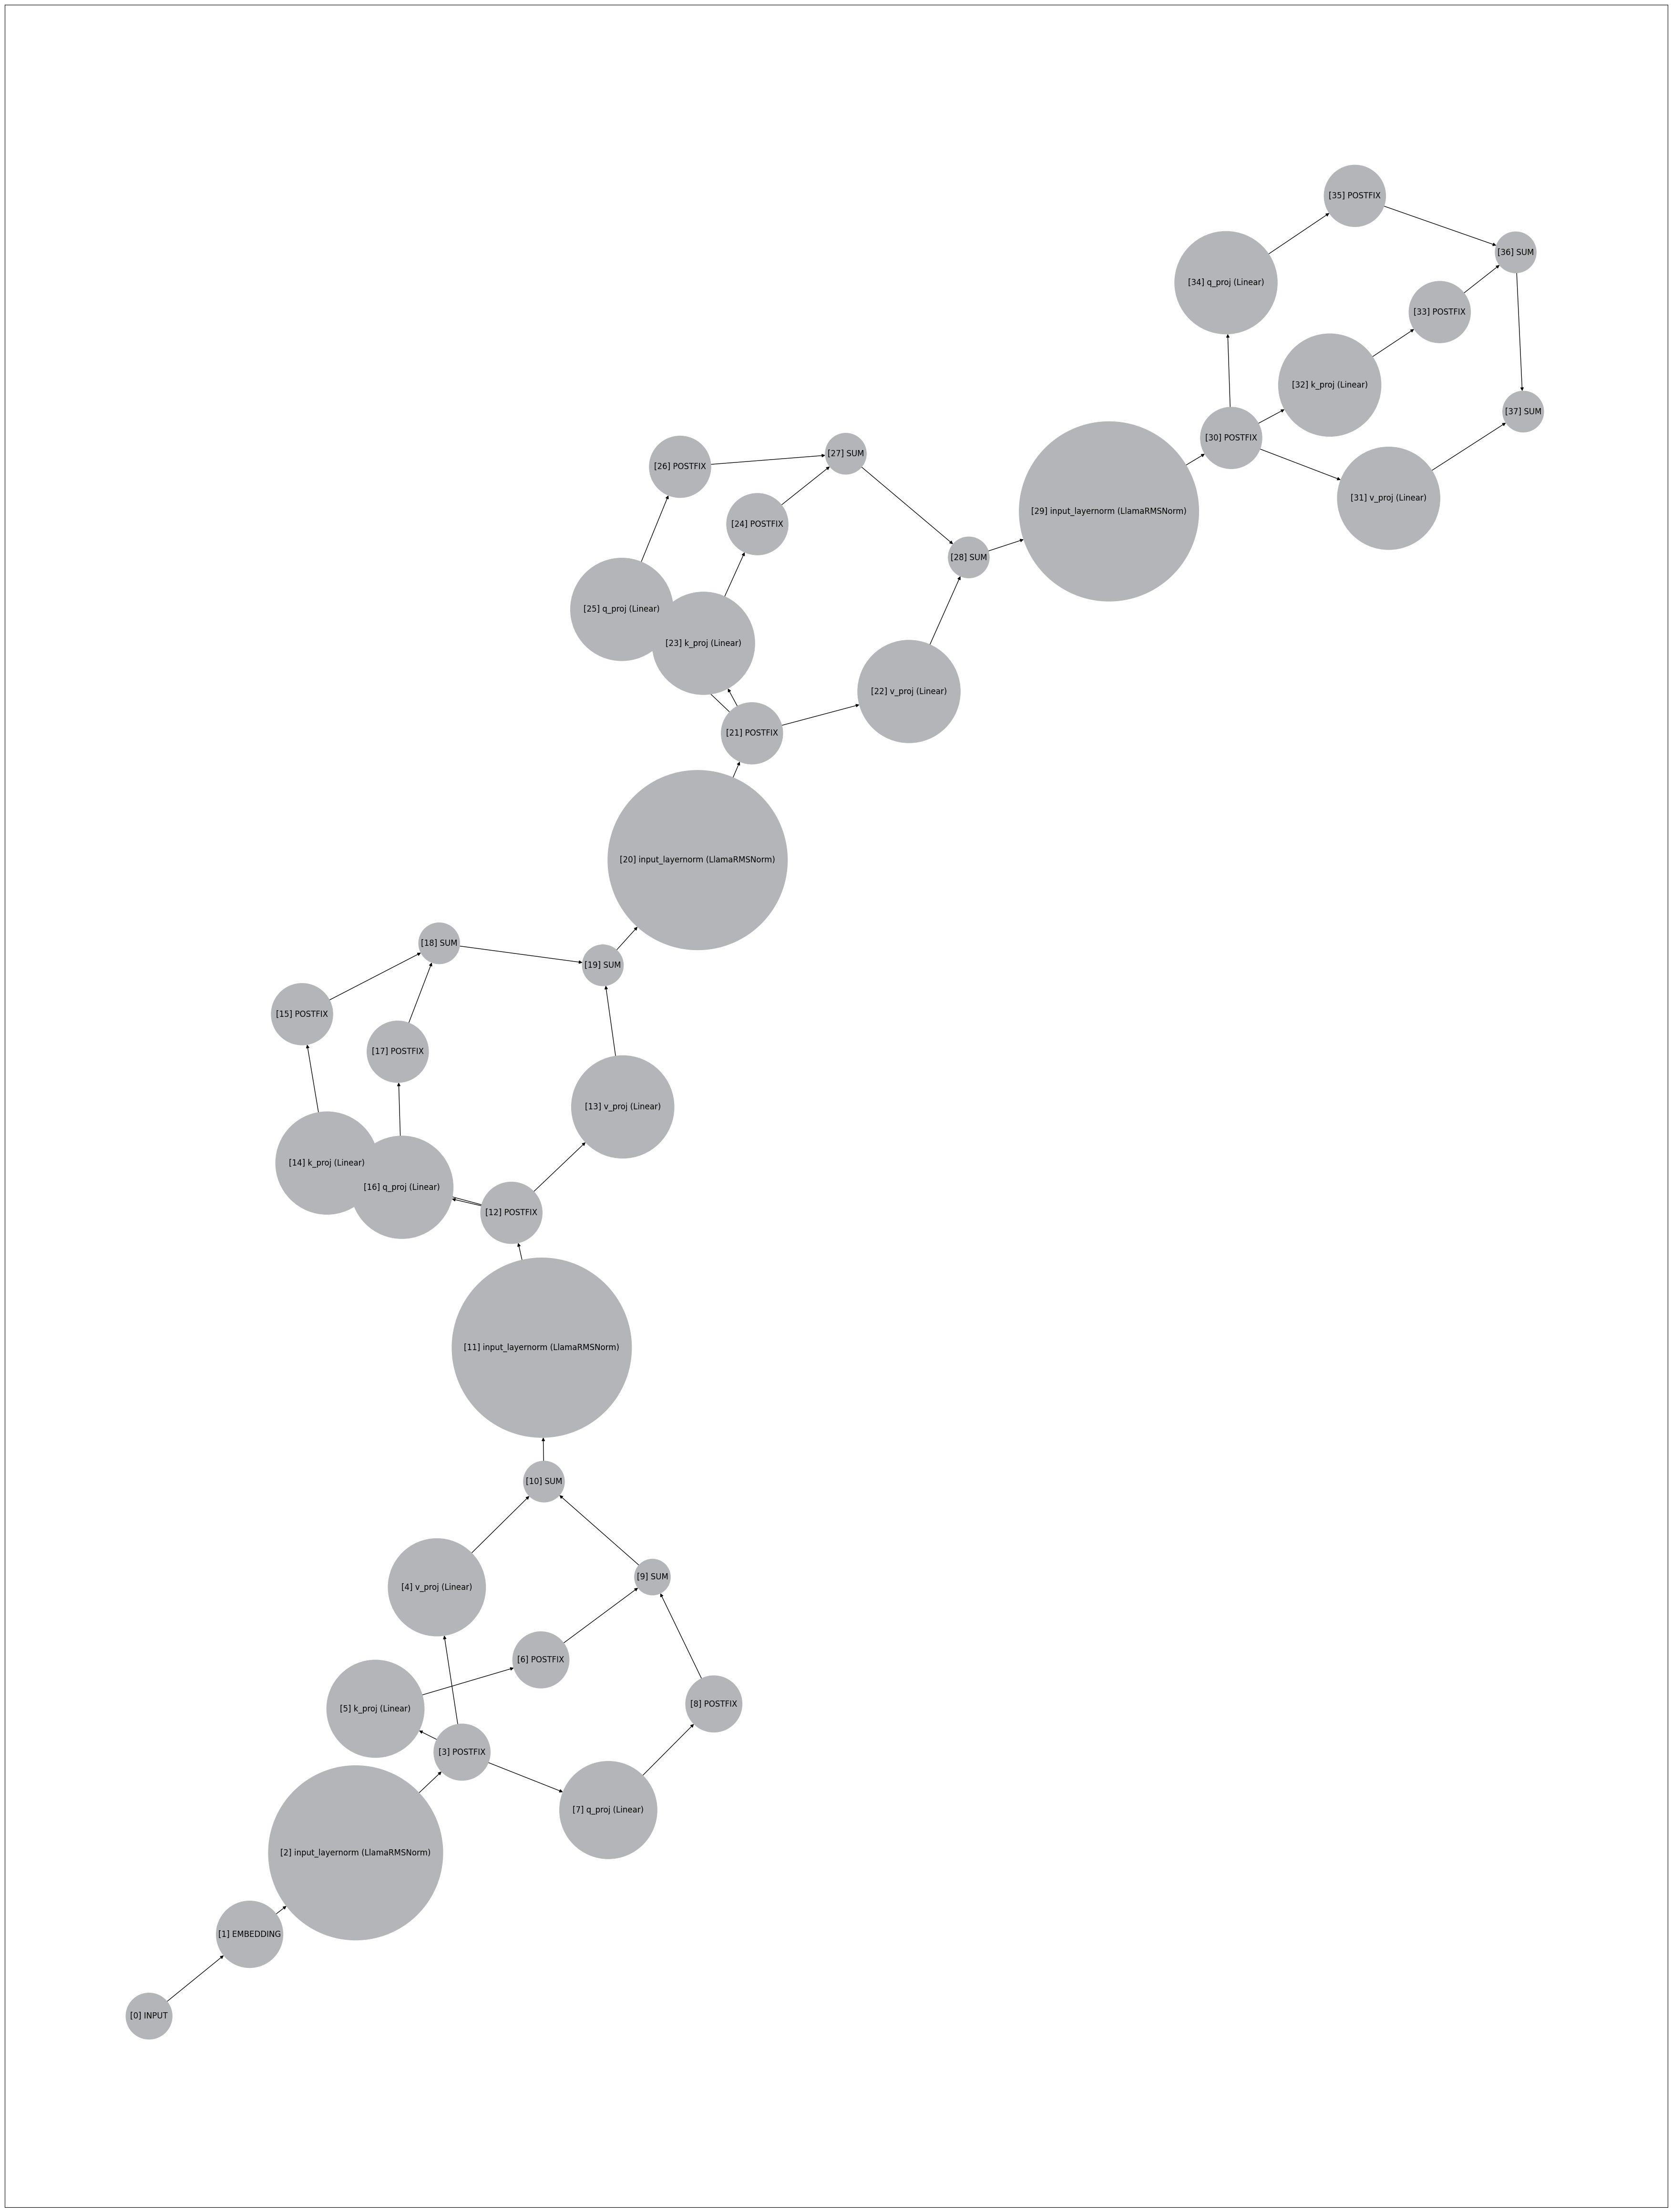

In [76]:
graph1.draw(figsize=(45, 60))

In [63]:
graph1.G.nodes[1]

{'layer': 'embed_tokens',
 'type': <NodeType.EMBEDDING: 7>,
 'param': 'embed_tokens.weight',
 'chunk': None,
 'special_merge': None}

In [16]:
from torchviz import make_dot


In [18]:
input_ids = torch.randint(0, 100, (1, 10))
input_ids = input_ids.to(model.device)
output = model(input_ids)

In [31]:
def forward_hook(module, input, output):
    return output

activation = {}
model.layers[3].register_forward_hook(lambda m, i, o: activation.update({'layer3': o}))
input_ids = torch.randint(0, 100, (1, 10))
input_ids = input_ids.to(model.device)
output = model(input_ids)

In [35]:
#output.last_hidden_state
dot = make_dot(activation['layer3'][0], params=dict(model.named_parameters()))
dot.render("llama_graph", format="png", cleanup=True)


'llama_graph.png'

In [12]:
params = []
for name,param in model.named_parameters():
    tmp_name = name
    if "layers." in name:
        # find the index of the second '.'
        second_dot_index = name.find('.', name.find('.') + 1)
        tmp_name = name[second_dot_index+1:]
    params.append(tmp_name)

unique_params = set(params)
print(unique_params)



{'mlp.up_proj.weight', 'self_attn.v_proj.weight', 'mlp.gate_proj.weight', 'embed_tokens.weight', 'self_attn.q_proj.weight', 'norm.weight', 'input_layernorm.weight', 'post_attention_layernorm.weight', 'self_attn.o_proj.weight', 'mlp.down_proj.weight', 'self_attn.k_proj.weight'}


In [13]:
for param in unique_params:
    print(param)

mlp.up_proj.weight
self_attn.v_proj.weight
mlp.gate_proj.weight
embed_tokens.weight
self_attn.q_proj.weight
norm.weight
input_layernorm.weight
post_attention_layernorm.weight
self_attn.o_proj.weight
mlp.down_proj.weight
self_attn.k_proj.weight


In [51]:
module_name_set = set()
modules = {}
for name, module in model.named_modules():
    if name == "layers":
        continue
    if "layers" in name and len(name.split(".")) == 2:
        #print("skipping ", name)
        continue
    if "layers" in name:
        second_dot_index = name.find('.', name.find('.') + 1)
        tmp_name = name[second_dot_index+1:]
        if len(tmp_name) > 0:
            module_name_set.add(tmp_name)
            modules[name] = module
    else:
        if name == "":
            continue
        module_name_set.add(name)
        modules[name] = module
print(module_name_set)


{'mlp.act_fn', 'embed_tokens', 'self_attn', 'mlp', 'self_attn.q_proj', 'input_layernorm', 'mlp.up_proj', 'self_attn.v_proj', 'mlp.gate_proj', 'norm', 'self_attn.k_proj', 'rotary_emb', 'self_attn.rotary_emb', 'post_attention_layernorm', 'mlp.down_proj', 'self_attn.o_proj'}


In [52]:
for name in sorted(list(module_name_set)):
    print(name)


embed_tokens
input_layernorm
mlp
mlp.act_fn
mlp.down_proj
mlp.gate_proj
mlp.up_proj
norm
post_attention_layernorm
rotary_emb
self_attn
self_attn.k_proj
self_attn.o_proj
self_attn.q_proj
self_attn.rotary_emb
self_attn.v_proj


In [53]:
modules["layers.1.self_attn.q_proj"]

Linear(in_features=576, out_features=576, bias=False)

In [48]:
len(modules)

393

In [50]:
modules[-8]

Linear(in_features=576, out_features=1536, bias=False)

In [41]:
dir(modules[-6])

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_is_hf_initialized',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_nam

In [44]:
list(modules[-6].named_modules())

[('', Linear(in_features=1536, out_features=576, bias=False))]

In [16]:
graph1 = graph1.graphify()
# todo: figure out when postfix and prefix are used
# todo: implement adding embedding (trivial)
# todo: implement llama decoder block
# todo: repeat llama decoder block for all layers
# todo: implment final 2 layers
# todo: figure out what we do for any output layers
# todo: check how to use positional embeddings if there are any after embedding layer

KeyError: 'emb'

In [38]:
for x in named_modules_dict["layers.29.mlp.up_proj"].parameters():
    print(x.shape)
    


torch.Size([1536, 576])
